In [1]:
from skripsi_program import LSSVR, FourierBasis
from sklearn.svm import SVR
import matplotlib.pyplot as plt
import torch
from ray import tune, train
from ray.tune.search.hyperopt import HyperOptSearch
from hyperopt import hp
# from torchmetrics.functional import r2_score
from sklearn.metrics import r2_score
import numpy as np

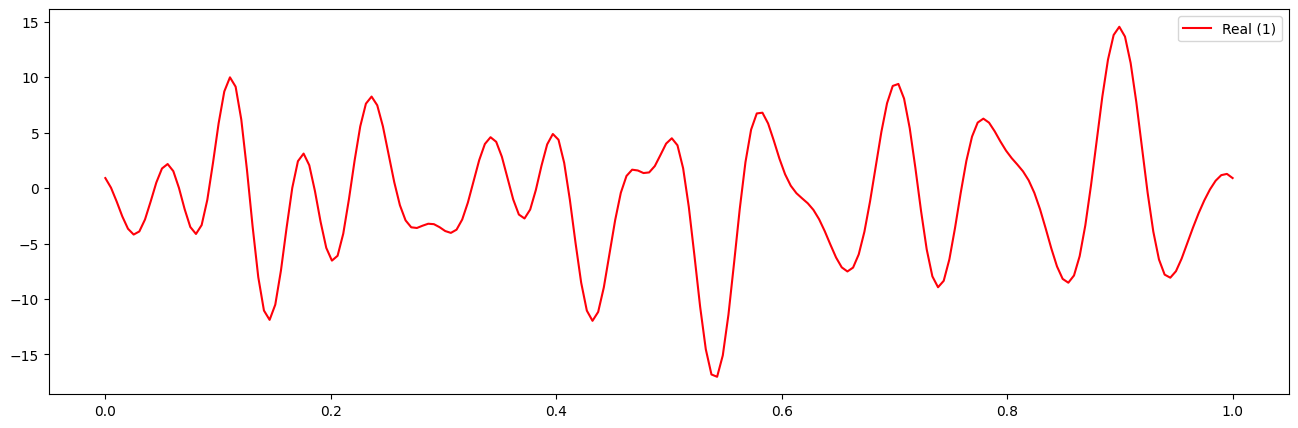

In [7]:
# Generate functions
func = FourierBasis.generate(1,40)
grid = FourierBasis.grid(10000)
plt.figure(figsize=(16,5))
func.plot()
plt.show()
f = func(grid).real.reshape((-1,1)).numpy()
x = grid.numpy()

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
f_train,f_test,x_train,x_test = train_test_split(f,x)
f_train,f_val,x_train,x_val = train_test_split(f_train,x_train,test_size=0.13)
scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
x_val = scaler.transform(x_val)

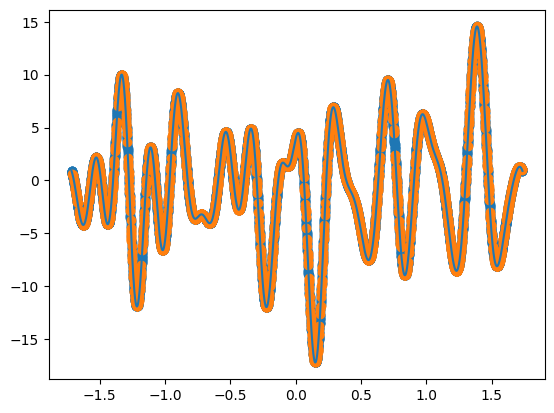

In [13]:
plt.plot(scaler.transform(x), f)
plt.scatter(x_train, f_train)
plt.scatter(x_test, f_test)


In [33]:
model = SVR(C=485,gamma=0.0199**-2)
%timeit model.fit(x_train,f_train.ravel())
%timeit model.predict(x_test)

2.15 s ± 93.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
521 ms ± 26.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [19]:
model, model._gamma

(SVR(C=485, gamma=2525.1887578596497), 2525.1887578596497)

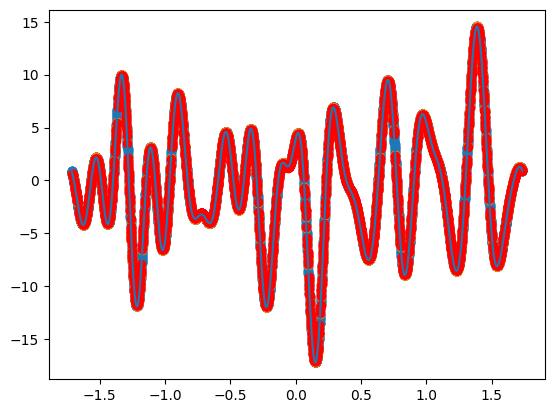

In [20]:
f_pred = model.predict(x_test)
plt.plot(scaler.transform(x),f)
plt.scatter(x_train,f_train)
plt.scatter(x_test,f_test)
plt.scatter(x_test,f_pred,color="r")

In [125]:
def search_param(config, data: tuple[np.ndarray, ...]):
    data = tuple(a.copy() for a in data)
    f_train, f_val, x_train, x_val = data

    model = LSSVR(
        device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
        **config["params"],
    )
    f_pred = model.fit(x_train, f_train).predict(x_val)
    r2 = r2_score(f_val, f_pred)
    train.report({"r2": r2})


search_space = {
    "params": hp.choice(
        "params",
        [
            {
                "kernel": "rbf",
                "sigma": hp.loguniform("sigma", -4, 2),
                "C": hp.loguniform("C_rbf", -6, 7),
            },
            #             {"kernel": "linear", "C": hp.loguniform("C_lin", -3, 8),},
            #             {"kernel": "poly", "d": hp.uniform("d",-7, 2.5),"C": hp.uniform("C", 0.0, 800.0),}, # dont use when data can be negative (d needs to be integer or input data needs to be all positive)
        ],
    ),
}
algo = HyperOptSearch(search_space, metric="r2", mode="max")
print("done setting up HyperOptSearch")
trainable_with_resources = tune.with_resources(search_param, {"cpu": 4, "gpu": 1})
trainable_with_params = tune.with_parameters(
    trainable_with_resources, data=(f_train, f_val, x_train, x_val)
)
tuner = tune.Tuner(
    trainable_with_params,
    tune_config=tune.TuneConfig(
        metric="r2",
        mode="max",
        num_samples=100,
        search_alg=algo,
    ),
)
print("done setting up tune.Tuner")
# Uncomment to find parameters
# results = tuner.fit()
print("done fitting")


2024-10-08 01:25:49,963	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to 'C:/Users/ahmad/ray_results/search_param_2024-10-08_01-10-38' in 0.2272s.
2024-10-08 01:25:50,089	INFO tune.py:1041 -- Total run time: 911.92 seconds (911.49 seconds for the tuning loop).


done fitting


In [126]:
# results.get_best_result()

Result(
  metrics={'r2': 0.9999998807907104},
  path='C:/Users/ahmad/ray_results/search_param_2024-10-08_01-10-38/search_param_0b70d884_14_C=485.8645,kernel=rbf,sigma=0.0199_2024-10-08_01-12-33',
  filesystem='local',
  checkpoint=None
)

In [34]:
# CPU LSSVR
model = LSSVR(C=485, device=torch.device("cpu"), sigma=0.0199)
# model.fit(x_train, f_train)
%timeit model.fit(x_train, f_train)
%timeit model.predict(x_test)

3.92 s ± 415 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
291 ms ± 16.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [35]:
model, model.kernel_params.get("sigma") ** -2, model.alpha.dtype

(<skripsi_program.model.LSSVR.LSSVR at 0x159095c7cd0>,
 2525.1887578596497,
 torch.float32)

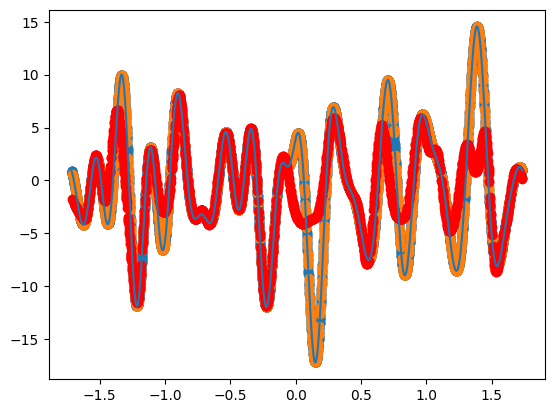

In [36]:
f_pred = model.predict(x_test)
plt.plot(scaler.transform(x),f)
plt.scatter(x_train,f_train)
plt.scatter(x_test,f_test)
plt.scatter(x_test,f_pred,color="r")

In [37]:
# GPU LSSVR
model = LSSVR(
    C=485,
    device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
    sigma=0.0199,
)
# model.fit(x_train, f_train)
%timeit model.fit(x_train, f_train)
%timeit model.predict(x_test)


384 ms ± 2.48 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
5.99 ms ± 149 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [38]:
model, model.kernel_params.get("sigma") ** -2, model.alpha.dtype

(<skripsi_program.model.LSSVR.LSSVR at 0x1594b78ba90>,
 2525.1887578596497,
 torch.float32)

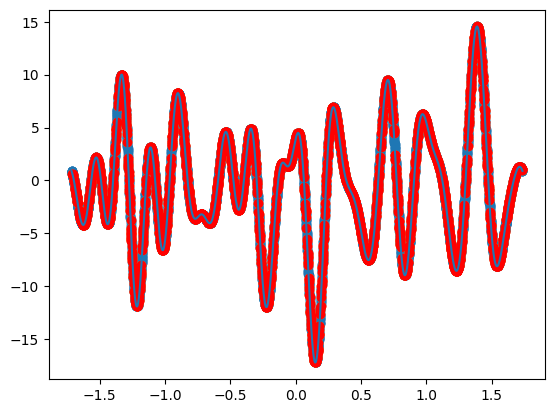

In [39]:
f_pred = model.predict(x_test)
plt.plot(scaler.transform(x),f)
plt.scatter(x_train,f_train)
plt.scatter(x_test,f_test)
plt.scatter(x_test,f_pred,color='r')